In [1]:
import numpy as np
import math
import logging
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

2022-12-12 19:14:02.217303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [212]:
#Load in data set and give the columns relavent titles
df = pd.read_excel('trainDataset.xls', index_col=False)
df.head()

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.0,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.0,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.0,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.0,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [213]:
df = df[~(df == 999).any(axis=1)]

In [214]:
df.reset_index()

,index,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,0,TRG002174,1,144.000000,41.0,0,0,0,1,3,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,1,TRG002178,0,142.000000,39.0,1,1,0,0,3,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,2,TRG002204,1,135.000000,31.0,0,0,0,1,2,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,3,TRG002206,0,12.000000,35.0,0,0,0,1,3,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,4,TRG002210,0,109.000000,61.0,1,0,0,0,2,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,395,TRG002955,1,49.250000,46.1,0,0,0,1,3,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
386,396,TRG002958,0,48.500000,53.3,0,0,0,1,2,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
387,397,TRG002961,0,47.500000,68.8,1,0,0,0,3,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
388,398,TRG002962,0,46.916667,46.0,1,0,0,0,2,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


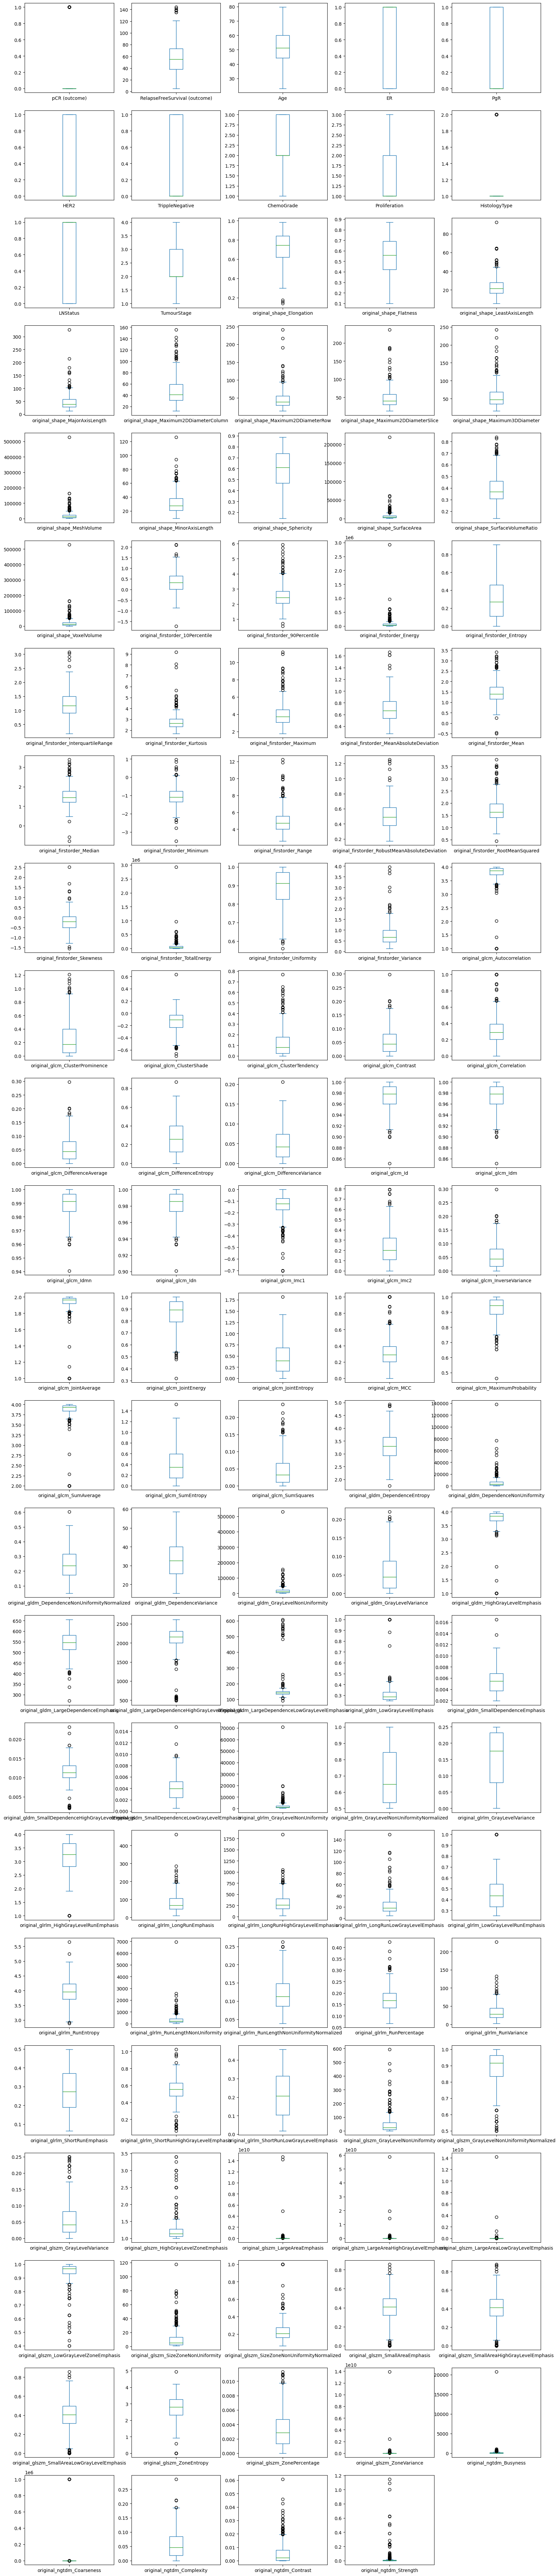

In [215]:
#graphs to see outliers and the spread of each of the features
data_mean = df.iloc[:, :]
data_mean.plot(kind='box', subplots=True, layout=(24,5), sharex=False, sharey=False, fontsize=10, figsize=(20,100));

In [216]:
df.info()
#list(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 399
Columns: 120 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(11), object(1)
memory usage: 368.7+ KB


In [7]:
df = df.drop('pCR (outcome)', axis=1)
df

,ID,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,144.000000,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,142.000000,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,135.000000,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,12.000000,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,109.000000,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,TRG002955,49.250000,46.1,0,0,0,1,3,3,1,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
396,TRG002958,48.500000,53.3,0,0,0,1,2,1,1,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
397,TRG002961,47.500000,68.8,1,0,0,0,3,3,1,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
398,TRG002962,46.916667,46.0,1,0,0,0,2,1,1,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


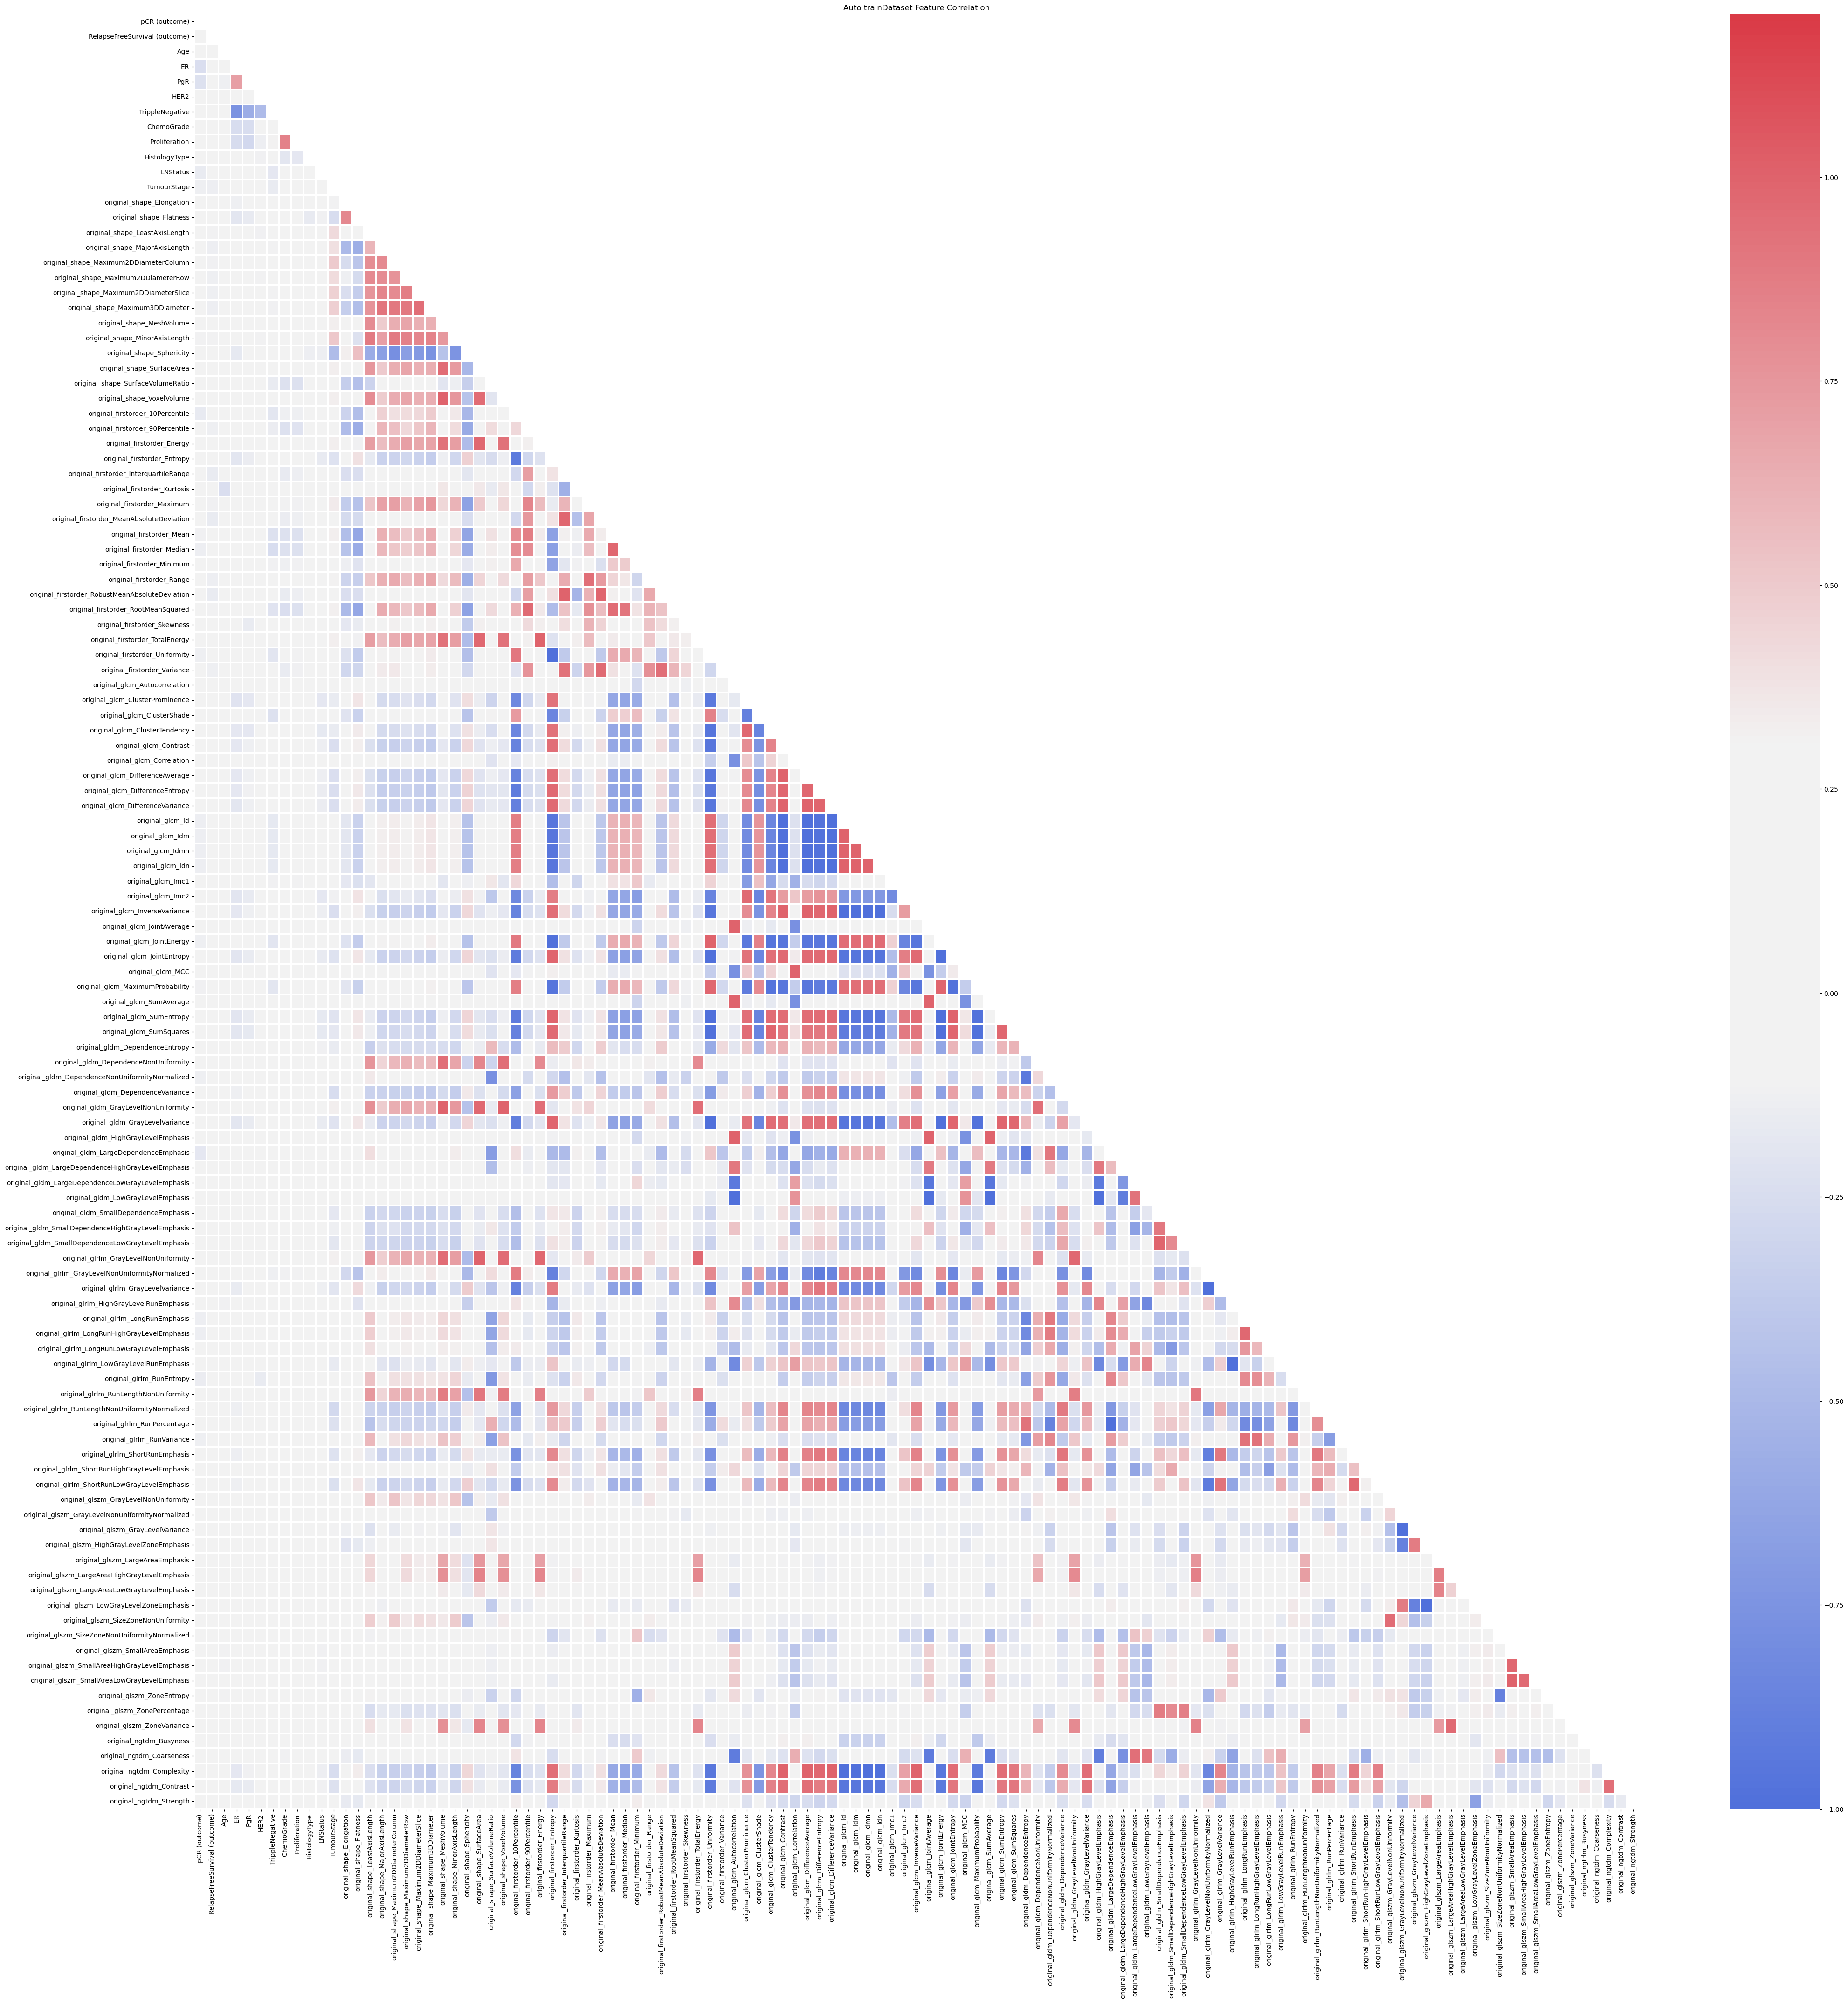

In [217]:
#graph showing the correlation between features to try to determine links between features
#to remove most of the noise as it is a large graph, only showing values with correlation over a certain threshold
#this threshold is determined and can be changed by the sensitivity variable

corrMatt = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(50, 50))
plt.title('Auto trainDataset Feature Correlation')
# Generate a custom diverging colormap
sensitivity = 76
cmap = sns.diverging_palette(260, 10, sep=201-2*sensitivity, as_cmap=True)
#cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask, ax=ax, annot=False, fmt='.2g', linewidths=2);


In [9]:
df

,ID,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,144.000000,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,142.000000,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,135.000000,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,12.000000,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,109.000000,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,TRG002955,49.250000,46.1,0,0,0,1,3,3,1,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
396,TRG002958,48.500000,53.3,0,0,0,1,2,1,1,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
397,TRG002961,47.500000,68.8,1,0,0,0,3,3,1,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
398,TRG002962,46.916667,46.0,1,0,0,0,2,1,1,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


In [10]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


#select the features being used to train model
X = df.drop(['RelapseFreeSurvival (outcome)', 'ID'], axis=1).to_numpy()
y = df['RelapseFreeSurvival (outcome)'].to_numpy()
#X = X.reshape((-1, 1))
X.shape

(390, 117)

In [11]:
#clf = ExtraTreesClassifier(n_estimators=50)
#clf = clf.fit(X, y)
#clf.feature_importances_
df

,ID,RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,144.000000,41.0,0,0,0,1,3,3,1,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,142.000000,39.0,1,1,0,0,3,3,1,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,135.000000,31.0,0,0,0,1,2,1,1,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,12.000000,35.0,0,0,0,1,3,3,1,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,109.000000,61.0,1,0,0,0,2,1,1,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,TRG002955,49.250000,46.1,0,0,0,1,3,3,1,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
396,TRG002958,48.500000,53.3,0,0,0,1,2,1,1,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
397,TRG002961,47.500000,68.8,1,0,0,0,3,3,1,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
398,TRG002962,46.916667,46.0,1,0,0,0,2,1,1,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
pca.fit(X)
PCA(n_components=2)

print(pca.explained_variance_ratio_)

[0.94311642 0.05605966]


In [13]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
# Machine learning systems work with integers, we need to encode these
# string characters into ints
#encoder = LabelEncoder()

In [188]:
# Now apply the transformation to all the columns:
#for col in df.columns:
#    df[col] = encoder.fit_transform(df[col])

####X_features = df.iloc[:,2:]
####y_label = df.iloc[:, 1]

X_features = df.drop(['RelapseFreeSurvival (outcome)', 'ID'], axis=1)
y_label = df['RelapseFreeSurvival (outcome)']

X_features2 = X_features
####
#tripple negative is redundant 
####

In [16]:
X_features
#y_label.shape

,Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,41.0,0,0,0,1,3,3,1,1,2,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,39.0,1,1,0,0,3,3,1,1,2,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,31.0,0,0,0,1,2,1,1,0,2,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,35.0,0,0,0,1,3,3,1,1,3,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,61.0,1,0,0,0,2,1,1,0,2,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,46.1,0,0,0,1,3,3,1,1,4,...,0.439568,0.439568,3.056046,0.001339,1.671271e+07,79.989003,0.003282,0.024716,0.000812,0.003078
396,53.3,0,0,0,1,2,1,1,0,2,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
397,68.8,1,0,0,0,3,3,1,1,3,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368
398,46.0,1,0,0,0,2,1,1,1,2,...,0.670229,0.670229,1.857045,0.006706,5.609262e+05,9.609163,0.026591,0.018682,0.000311,0.022676


In [17]:
# Scale the features
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

In [18]:
X_features[:,10:].shape
X_features_regression = X_features[:,10:] 

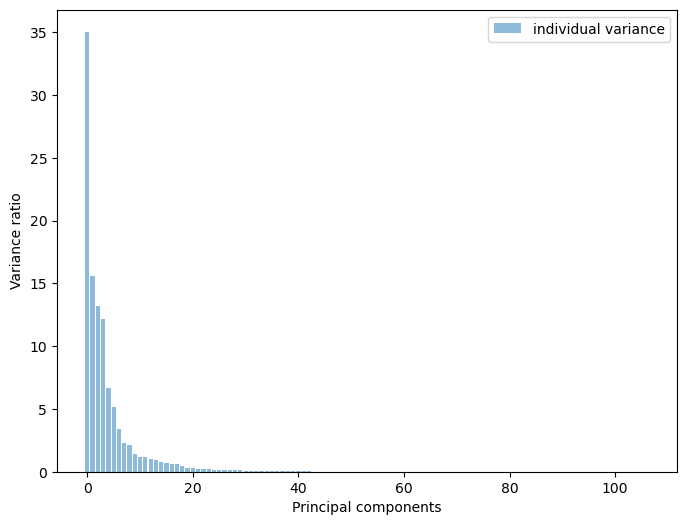

In [19]:
# Visualize
pca = PCA()
pca.fit_transform(X_features_regression)
pca_variance = pca.explained_variance_

plt.figure(figsize=(8, 6))
plt.bar(range(107), pca_variance, alpha=0.5, align='center', label='individual variance')
plt.legend()
plt.ylabel('Variance ratio')
plt.xlabel('Principal components')
plt.show()

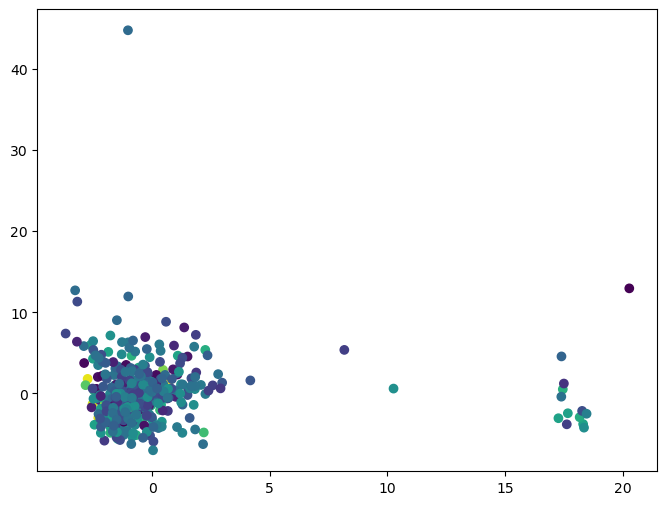

(390, 10)

In [20]:
pca2 = PCA(n_components=0.9)
pca2.fit(X_features_regression)
x_3d = pca2.transform(X_features_regression)

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,2], x_3d[:,1], c=df['RelapseFreeSurvival (outcome)'])
#plt.scatter(x_3d[:,0], x_3d[:,5], c=df['Age'])
plt.show()

x_3d.shape

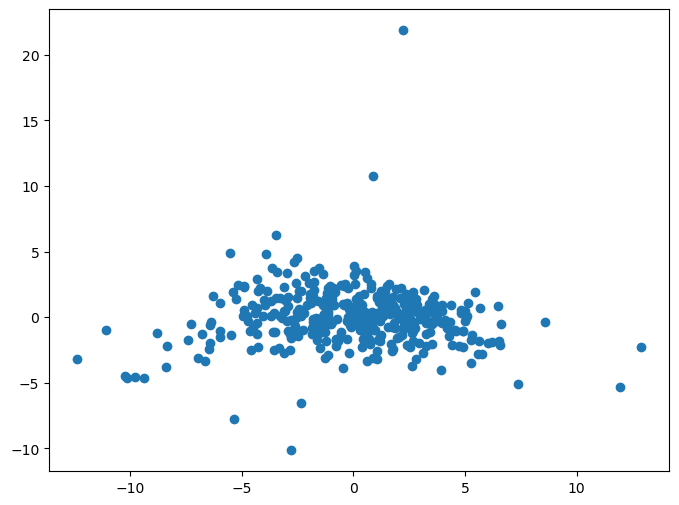

In [21]:
plt.figure(figsize=(8,6))
#plt.scatter(x_3d[:,2], x_3d[:,1], c=df['RelapseFreeSurvival (outcome)'])
#plt.scatter(x_3d[:,0], x_3d[:,5], c=df['Age'])
plt.scatter(x_3d[:,3], x_3d[:,5])
plt.show()

In [22]:
x_3d = x_3d[:,0:3] #retain the first 3 PC
x_3d.shape

(390, 3)

In [23]:
"""pca3 = PCA(n_components=2)
pca3.fit(X_features)
x_3d = pca3.transform(X_features)

plt.figure(figsize=(8,6))
plt.scatter(x_3d[:,0], x_3d[:,1], c=df['RelapseFreeSurvival (outcome)'])
plt.show()"""

"pca3 = PCA(n_components=2)\npca3.fit(X_features)\nx_3d = pca3.transform(X_features)\n\nplt.figure(figsize=(8,6))\nplt.scatter(x_3d[:,0], x_3d[:,1], c=df['RelapseFreeSurvival (outcome)'])\nplt.show()"

In [24]:
type(x_3d)

numpy.ndarray

In [25]:
y_label

0      144.000000
1      142.000000
2      135.000000
3       12.000000
4      109.000000
          ...    
395     49.250000
396     48.500000
397     47.500000
398     46.916667
399     46.750000
Name: RelapseFreeSurvival (outcome), Length: 390, dtype: float64

In [26]:
# create the model
# regression so using ReLU

model=keras.models.Sequential()
model.add(keras.layers.Dense(10, input_dim=3,activation="relu"))
model.add(keras.layers.Dense(20,activation="relu"))
model.add(keras.layers.Dense(1,activation='relu'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


2022-12-12 19:14:16.104367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [27]:
model.compile(loss="mse", optimizer="sgd", metrics=["accuracy"])
#model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001), metrics=["accuracy"])
#model.compile(loss="mean_absolute_error", optimizer="sgd", metrics=["accuracy"])
# save the initial weight for initilise new models in cross validation
model.save_weights('model.h5')

In [28]:
# split data to train and test 80/20
#Xs_train, Xs_test, y_train, y_test = train_test_split(x_3d, y_label, test_size=0.2, random_state=1, stratify=y_label)
Xs_train, Xs_test, y_train, y_test = train_test_split(x_3d, y_label, test_size=0.2, random_state=1)
y_test

94     78.0
181    31.0
128    46.0
63      9.0
230    46.0
       ... 
79     87.0
396    48.5
164    61.0
276    11.0
190    59.0
Name: RelapseFreeSurvival (outcome), Length: 78, dtype: float64

In [29]:
# start training
# Tensorflow/Keras uses np array, so need to convert the data format
# make sure the weights are initialised
model.load_weights('model.h5')
# Model learning
history= model.fit(np.array(Xs_train), np.array(y_train), epochs=50, validation_data=(np.array(Xs_test), np.array(y_test)))

Epoch 1/50
10/10 [==============================] - 0s 11ms/step - loss: 57346.0820 - accuracy: 0.0000e+00 - val_loss: 3806.4504 - val_accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 0s 2ms/step - loss: 3861.1714 - accuracy: 0.0000e+00 - val_loss: 3806.4504 - val_accuracy: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 3861.1714 - accuracy: 0.0000e+00 - val_loss: 3806.4504 - val_accuracy: 0.0000e+00
Epoch 4/50
10/10 [==============================] - 0s 3ms/step - loss: 3861.1714 - accuracy: 0.0000e+00 - val_loss: 3806.4504 - val_accuracy: 0.0000e+00
Epoch 5/50
10/10 [==============================] - 0s 3ms/step - loss: 3861.1711 - accuracy: 0.0000e+00 - val_loss: 3806.4504 - val_accuracy: 0.0000e+00
Epoch 6/50
10/10 [==============================] - 0s 3ms/step - loss: 3861.1714 - accuracy: 0.0000e+00 - val_loss: 3806.4504 - val_accuracy: 0.0000e+00
Epoch 7/50
10/10 [==============================] - 0s 2ms/step - loss: 38

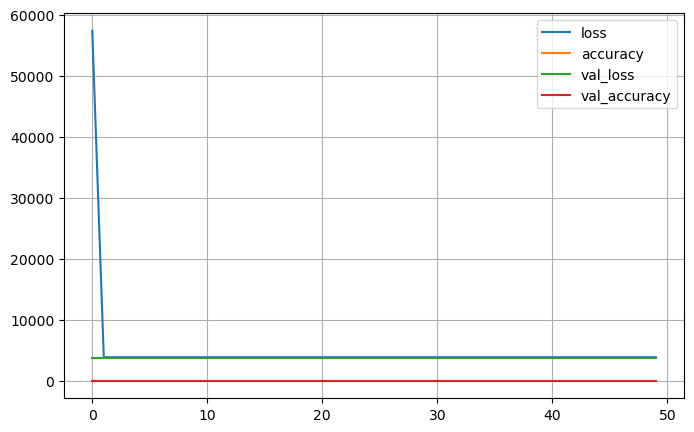

In [30]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

# Decision Tree

In [110]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=5).fit(Xs_train, y_train)
list(df)
headings = list(df)
headings.remove("RelapseFreeSurvival (outcome)")
#headings

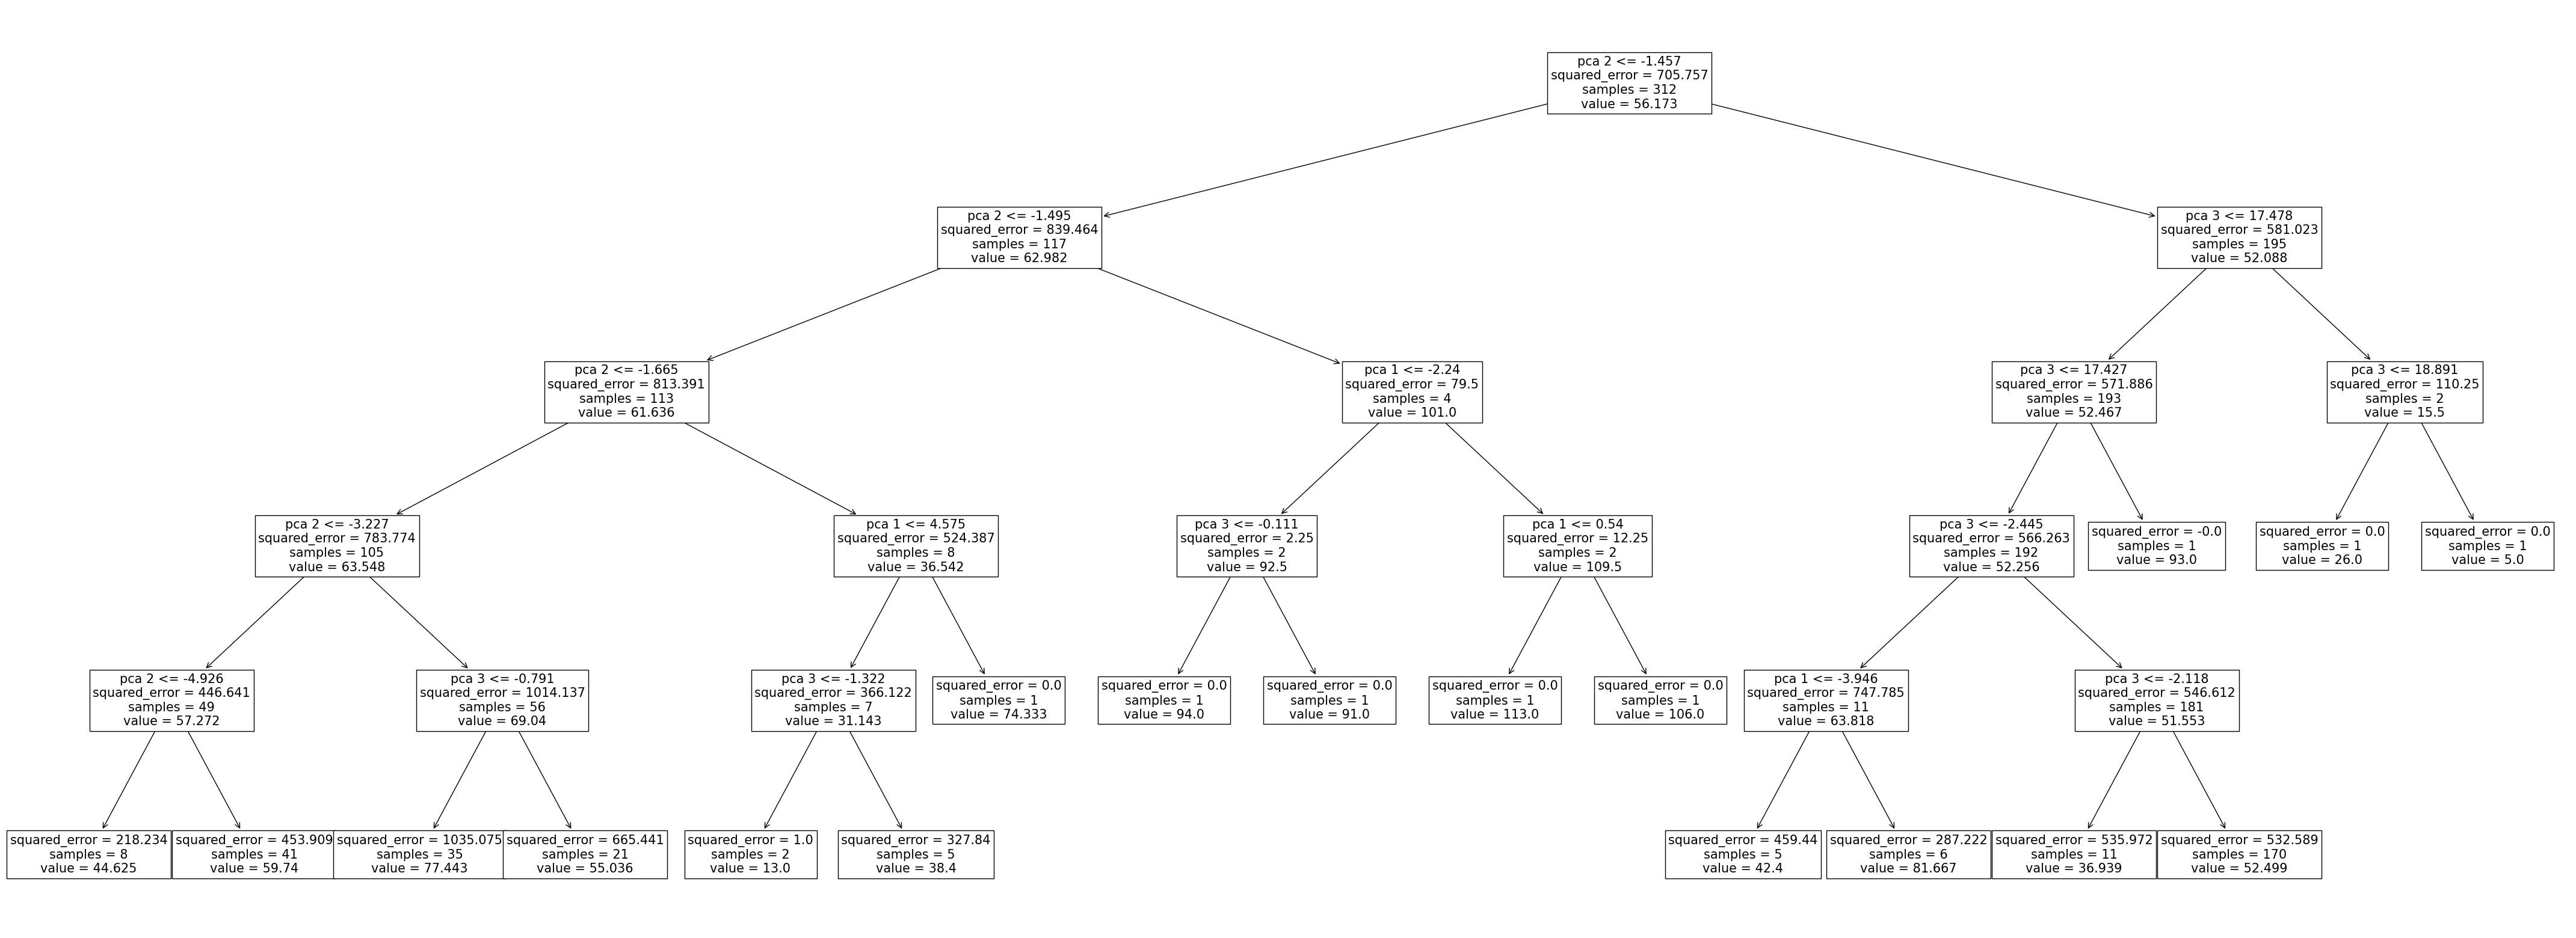

In [114]:
from sklearn import tree


plt.figure(figsize=(55,20))  
_ = tree.plot_tree(dt, feature_names = ["pca 1", "pca 2", "pca 3"], fontsize=15)
plt.show()

In [210]:
from sklearn.metrics import accuracy_score

dt.score(Xs_train, y_train)

#y_predict_dt = dt.predict(Xs_train) #testing the trained decision tree model
#print(sk.metrics.accuracy_score(y_train, y_predict_dt)) #evaluate the trained model on the testing data

0.05238756317933513

In [211]:
#y_predict_dt1 = dt1.predict(x_test) #testing the trained decision tree model
#print(metrics.accuracy_score(y_test, y_predict_dt1)) #evaluate the trained model on the testing data

dt.score(Xs_test, y_test)

-0.08786213715724944

# Decision Tree with non PCA data

In [197]:
Xs_train, Xs_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=1)

In [198]:
dt = DecisionTreeRegressor(max_depth=4).fit(Xs_train, y_train)

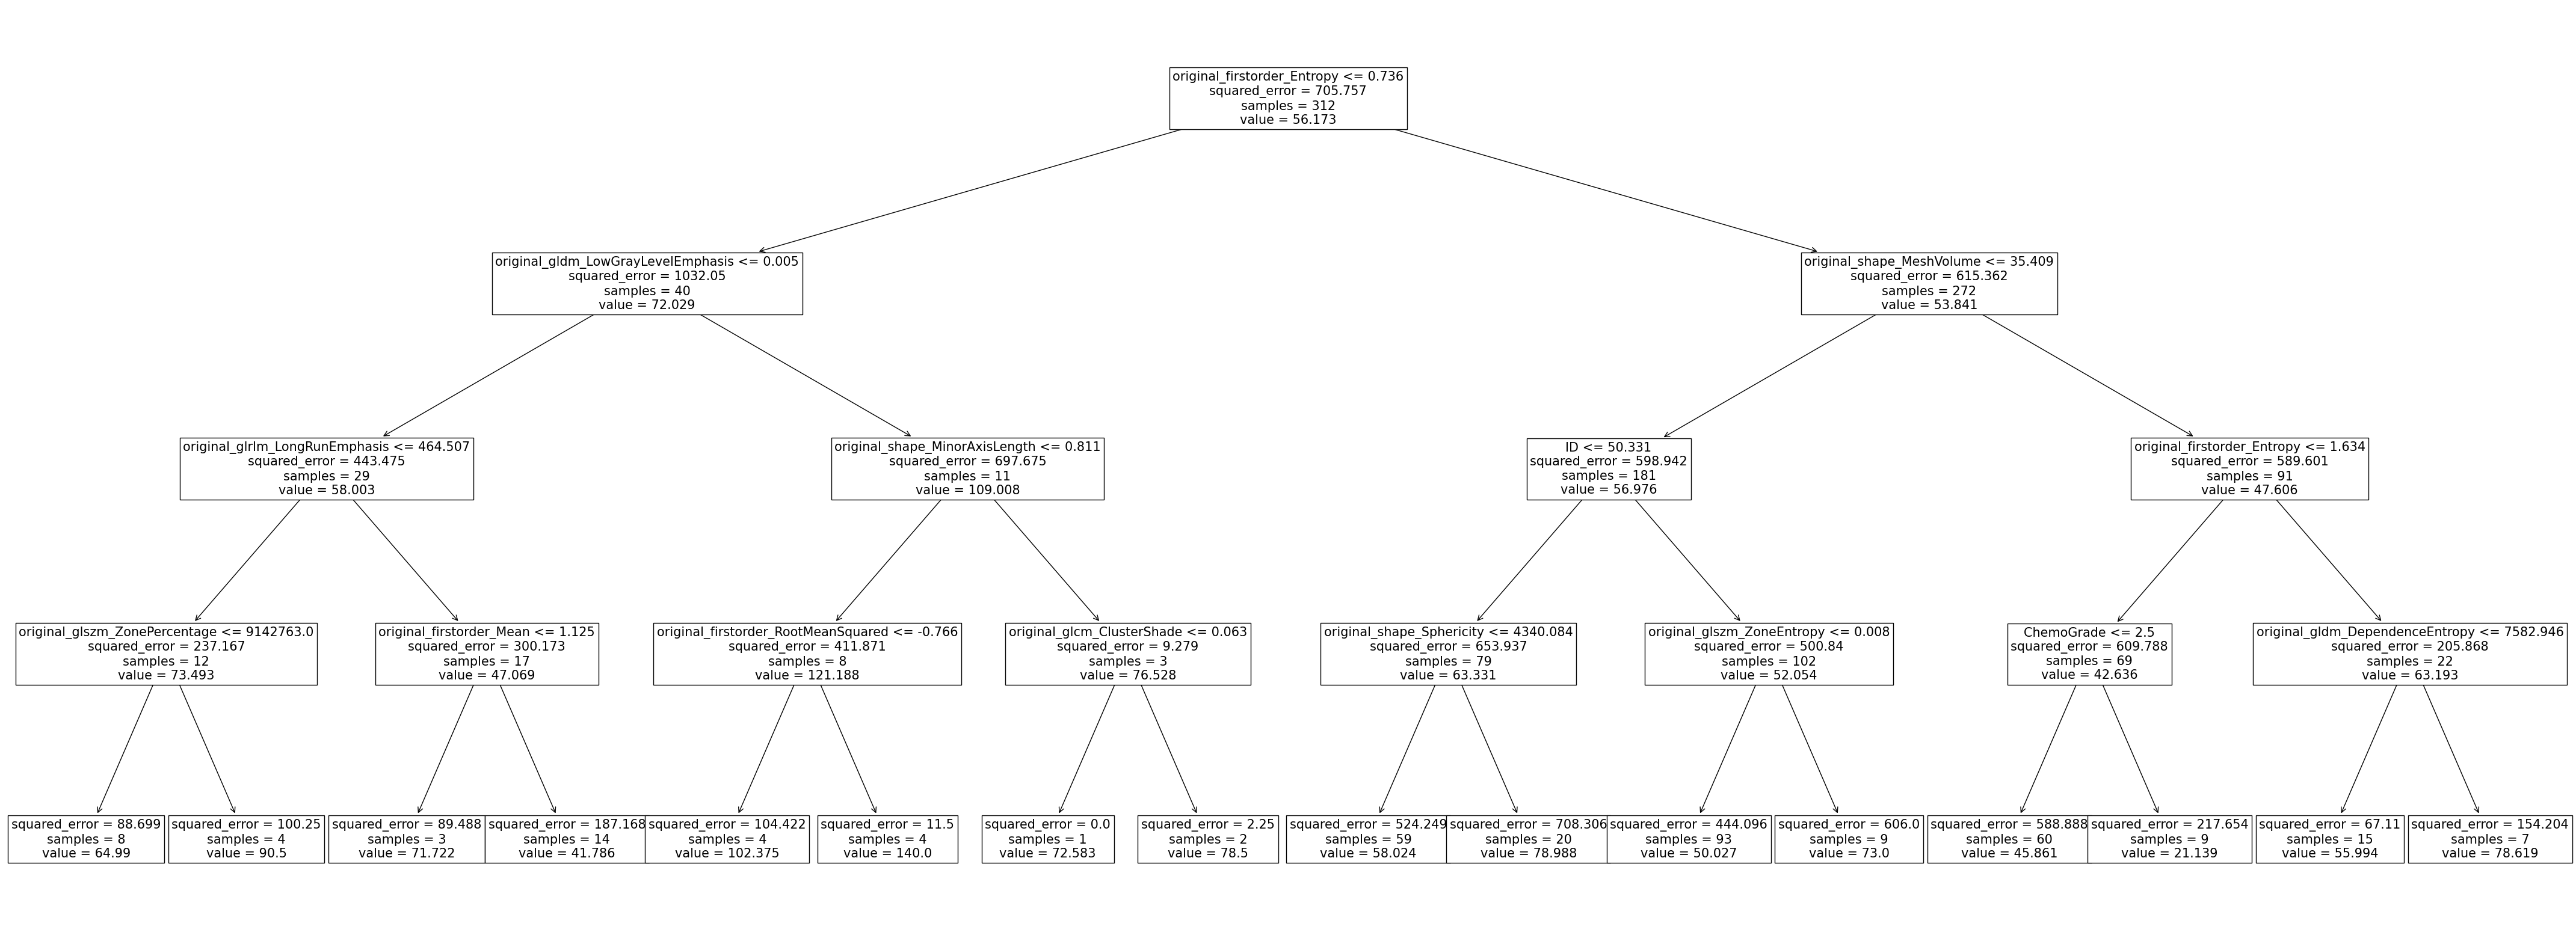

In [199]:
plt.figure(figsize=(55,20))  
_ = tree.plot_tree(dt, feature_names = headings, fontsize=15)
plt.show()

In [200]:
dt.score(Xs_train, y_train)

0.38374221974661515

In [201]:
dt.score(Xs_test, y_test)

-0.3565833919762895

In [227]:
best_depth = 1
best_accuracy = -100000000000

for i in range(4, 50):
    dt = DecisionTreeRegressor(max_depth=i).fit(Xs_train, y_train)
    score = dt.score(Xs_test, y_test)
    if score > best_accuracy:
        best_accuracy = score
        best_depth = i
        
print("best depth: {}\nbest accuracy: {}".format(best_depth, best_accuracy))

#16 was best depth

best depth: 4
best accuracy: -0.3565833919762895


In [208]:
test = df[0:1]
test = test.drop(["ID", "RelapseFreeSurvival (outcome)"], axis = 1)
result = df[0:1]
result = result["RelapseFreeSurvival (outcome)"]
result

0    144.0
Name: RelapseFreeSurvival (outcome), dtype: float64

In [209]:
dt.predict(test)

array([72.02916667])